# Spatial clustering and denoising expressions

STAGATE is designed for spatial clustering and denoising expressions of spatial resolved transcriptomics (ST) data.

STAGATE learns low-dimensional latent embeddings with both spatial information and gene expressions via a graph attention auto-encoder. The method adopts an attention mechanism in the middle layer of the encoder and decoder, which adaptively learns the edge weights of spatial neighbor networks, and further uses them to update the spot representation by collectively aggregating information from its neighbors. The latent embeddings and the reconstructed expression profiles can be used to downstream tasks such as spatial domain identification, visualization, spatial trajectory inference, data denoising and 3D expression domain extraction.

Dong, Kangning, and Shihua Zhang. “Deciphering spatial domains from spatially resolved transcriptomics with an adaptive graph attention auto-encoder.” Nature Communications 13.1 (2022): 1-12.

![fig](https://stagate.readthedocs.io/en/latest/_images/StaGATE_Fig1.png)


In [1]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.0, Tutorials: https://omicverse.readthedocs.io/


## Preprocess data

Here we present our re-analysis of 151676 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

This tutorial demonstrates how to identify spatial domains on 10x Visium data using STAGATE. The processed data are available at https://github.com/LieberInstitute/spatialLIBD. We downloaded the manual annotation from the spatialLIBD package and provided at https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

In [2]:
adata = sc.read_visium(path='data', count_file='151676_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading data/151676_filtered_feature_bc_matrix.h5
 (0:00:00)


<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    We introduced the spatial special svg calculation module prost in omicverse versions greater than `1.6.0` to replace scanpy's HVGs, if you want to use scanpy's HVGs you can set mode=`scanpy` in `ov.space.svg` or use the following code.
  </p>
</div>

```python
#adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
#adata.raw = adata
#adata = adata[:, adata.var.highly_variable_features]
```

In [3]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:,adata.var['total_counts']>100]
adata=ov.space.svg(adata,mode='prost',n_svgs=3000,target_sum=1e4,platform="visium",)
adata.raw = adata
adata = adata[:, adata.var.space_variable_features]
adata


Filtering genes ...

Calculating image index 1D:


100%|██████████| 3460/3460 [00:00<00:00, 16852.03it/s]



Normalize each geneing...

Gaussian filtering...


100%|██████████| 5779/5779 [00:13<00:00, 433.73it/s]



Binary segmentation for each gene:


100%|██████████| 5779/5779 [00:14<00:00, 388.01it/s]



Spliting subregions for each gene:


100%|██████████| 5779/5779 [00:35<00:00, 161.03it/s]



Computing PROST Index for each gene:


100%|██████████| 5779/5779 [00:03<00:00, 1829.31it/s]



PROST Index calculation completed !!
PI calculation is done!


100%|██████████| 5779/5779 [03:13<00:00, 29.79it/s]

Spatial autocorrelation test is done!
normalizing counts per cell
    finished (0:00:00)


normalization and log1p are done!
3000 SVGs are selected!


View of AnnData object with n_obs × n_vars = 3460 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'image_idx_1d'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SEP', 'SIG', 'PI', 'Moran_I', 'Geary_C', 'p_norm', 'p_rand', 'fdr_norm', 'fdr_rand', 'selected'
    uns: 'spatial', 'grid_size', 'locates', 'nor_counts', 'gau_fea', 'binary_image', 'subregions', 'del_index', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

We read the ground truth area of our spatial data

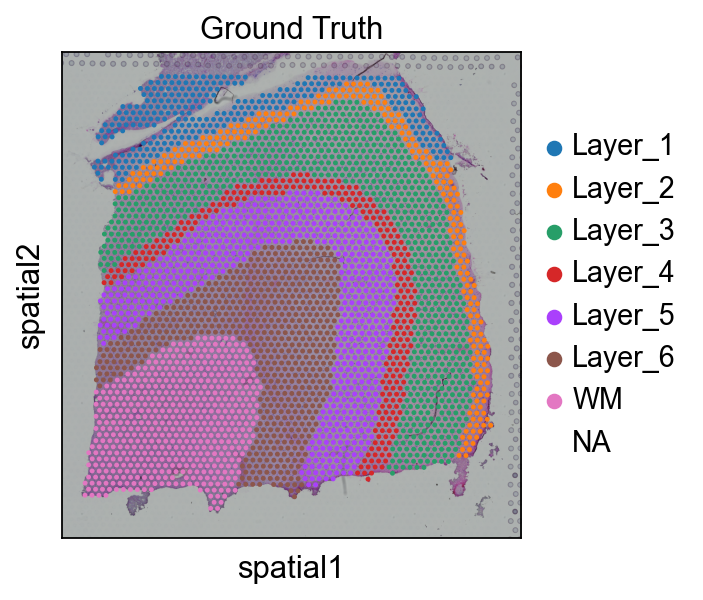

In [4]:
# read the annotation
import pandas as pd
import os
Ann_df = pd.read_csv(os.path.join('data', '151676_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

In [6]:
adata.obs['X'] = adata.obsm['spatial'][:,0]
adata.obs['Y'] = adata.obsm['spatial'][:,1]

## Training STAGATE model

Here, we used `ov.space.pySTAGATE` to construct a STAGATE object to train the model. 

Because we build the spatial network based on spatial location, our network can be directly divided into subgraphs in the following form.

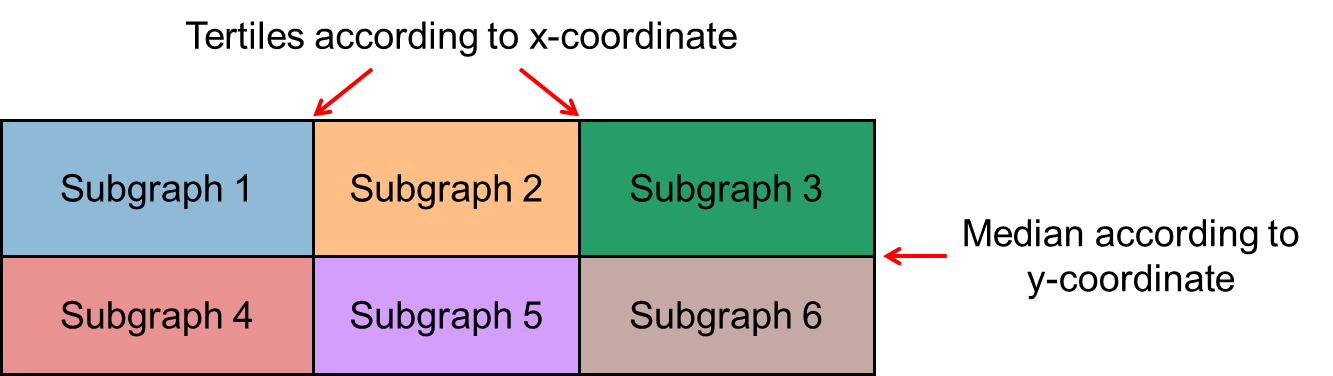

------Calculating spatial graph...
The graph contains 3060 edges, 559 cells.
5.4741 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3328 edges, 595 cells.
5.5933 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3448 edges, 613 cells.
5.6248 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3044 edges, 541 cells.
5.6266 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3128 edges, 559 cells.
5.5957 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 3320 edges, 595 cells.
5.5798 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


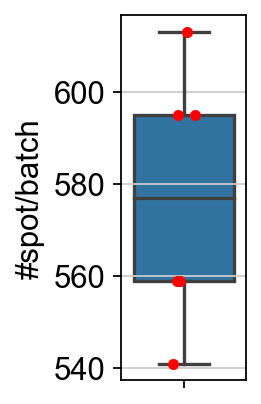

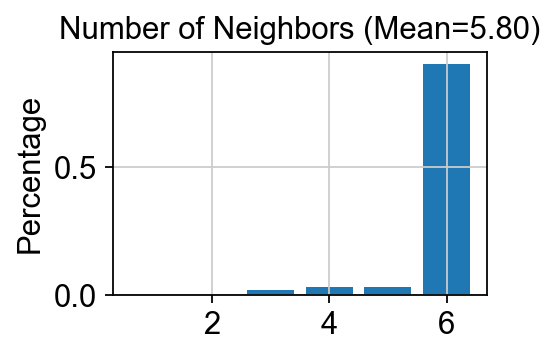

In [7]:
STA_obj=ov.space.pySTAGATE(adata,num_batch_x=3,num_batch_y=2,
                 spatial_key=['X','Y'],rad_cutoff=200,num_epoch = 1000,lr=0.001,
                weight_decay=1e-4,hidden_dims = [512, 30],
                device='cuda:0')

In [8]:
STA_obj.train()

100%|██████████| 1000/1000 [00:18<00:00, 52.83it/s]


We stored the latent embedding in `adata.obsm['STAGATE']`, and denoising expression in `adata.layers['STAGATE_ReX']`

In [9]:
STA_obj.predicted()
adata

The STAGATE representation values are stored in adata.obsm["STAGATE"].
The ReX values are stored in adata.layers["STAGATE_ReX"].


AnnData object with n_obs × n_vars = 3460 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'image_idx_1d', 'Ground Truth', 'X', 'Y'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SEP', 'SIG', 'PI', 'Moran_I', 'Geary_C', 'p_norm', 'p_rand', 'fdr_norm', 'fdr_rand', 'selected'
    uns: 'spatial', 'grid_size', 'locates', 'nor_counts', 'gau_fea', 'binary_image', 'subregions', 'del_index', 'log1p', 'Ground Truth_colors', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'
    layers: 'counts', 'STAGATE_ReX'

## Clustering the space

We can use `GMM`, `leiden` or `louvain` to cluster the space.

```python
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='STAGATE')
ov.utils.cluster(adata,use_rep='STAGATE',method='louvain',resolution=1)
ov.utils.cluster(adata,use_rep='STAGATE',method='leiden',resolution=1)
```

In [12]:
ov.utils.cluster(adata,use_rep='STAGATE',method='GMM',n_components=7,covariance_type='full',
                      tol=1e-9, max_iter=1000, random_state=307)

running GaussianMixture clustering
finished: found 7 clusters and added
    'gmm_cluster', the cluster labels (adata.obs, categorical)


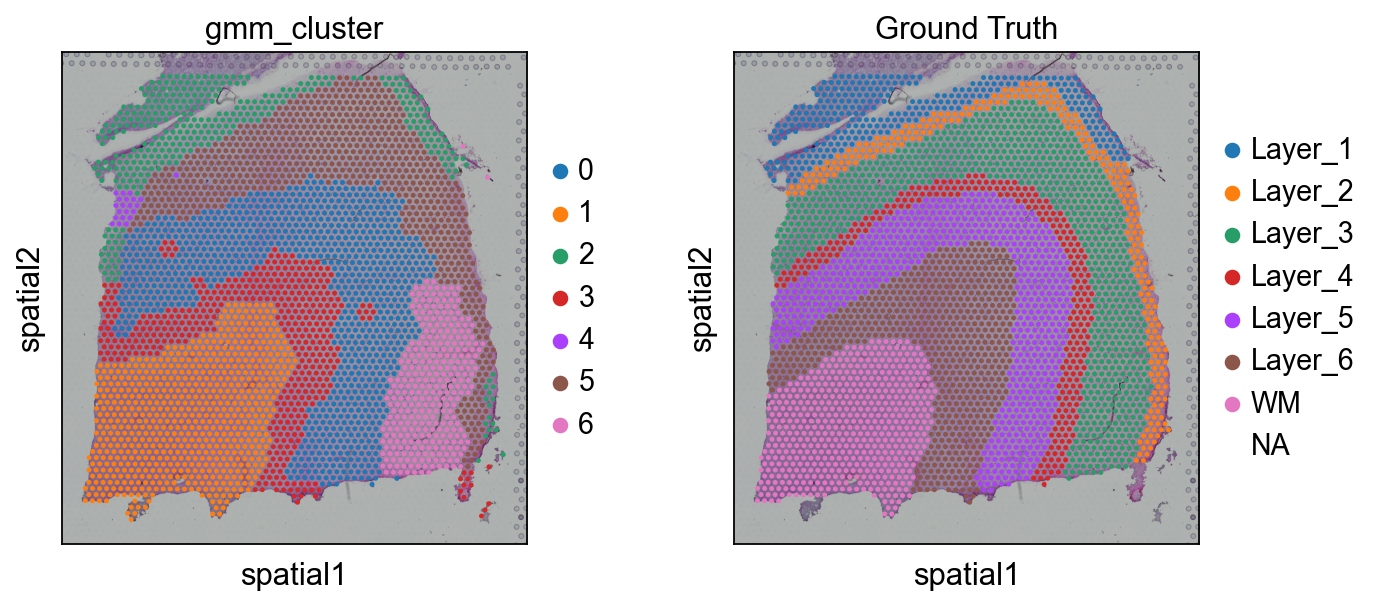

In [13]:
sc.pl.spatial(adata, color=['gmm_cluster',"Ground Truth"])

## Denoising

In [21]:
adata.var.sort_values('PI',ascending=False).head(10)

,gene_ids,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,SEP,SIG,PI,Moran_I,Geary_C,p_norm,p_rand,fdr_norm,fdr_rand,selected
MBP,ENSG00000197971,Gene Expression,GRCh38,3411,15.419075,2.798444,1.416185,53350.0,10.884648,3411,0.823299,0.214148,1.000000,0.910362,0.092733,0.0,0.0,0.0,0.0,True
GFAP,ENSG00000131095,Gene Expression,GRCh38,2938,3.930347,1.595409,15.086705,13599.0,9.517825,2938,0.694169,0.129941,0.587889,0.743831,0.255528,0.0,0.0,0.0,0.0,True
PLP1,ENSG00000123560,Gene Expression,GRCh38,3214,9.255780,2.327842,7.109827,32025.0,10.374304,3214,0.668771,0.099919,0.478698,0.737326,0.264750,0.0,0.0,0.0,0.0,True
MT-ND1,ENSG00000198888,Gene Expression,GRCh38,3460,74.200577,4.320159,0.000000,256734.0,12.455800,3460,0.362000,0.163292,0.359299,0.740392,0.262487,0.0,0.0,0.0,0.0,True
MT-CO1,ENSG00000198804,Gene Expression,GRCh38,3460,115.025436,4.753809,0.000000,397988.0,12.894179,3460,0.472005,0.100106,0.338241,0.755924,0.246897,0.0,0.0,0.0,0.0,True
MT-ATP6,ENSG00000198899,Gene Expression,GRCh38,3460,76.530922,4.350677,0.000000,264797.0,12.486723,3460,0.381374,0.129374,0.322039,0.739112,0.261844,0.0,0.0,0.0,0.0,True
CRYAB,ENSG00000109846,Gene Expression,GRCh38,2585,2.397688,1.223095,25.289017,8296.0,9.023649,2585,0.532278,0.065422,0.300814,0.583819,0.419295,0.0,0.0,0.0,0.0,True
CNP,ENSG00000173786,Gene Expression,GRCh38,2507,2.482948,1.247879,27.543353,8591.0,9.058587,2507,0.541763,0.056235,0.284438,0.608356,0.392351,0.0,0.0,0.0,0.0,True
MT-CO3,ENSG00000198938,Gene Expression,GRCh38,3460,98.956650,4.604737,0.000000,342390.0,12.743709,3460,0.435058,0.083730,0.280653,0.738370,0.262784,0.0,0.0,0.0,0.0,True
MT-CO2,ENSG00000198712,Gene Expression,GRCh38,3460,96.914742,4.584097,0.000000,335325.0,12.722858,3460,0.413118,0.086952,0.272313,0.739985,0.261256,0.0,0.0,0.0,0.0,True


[<AxesSubplot: title={'center': 'STAGATE_MBP'}, xlabel='spatial1', ylabel='spatial2'>]

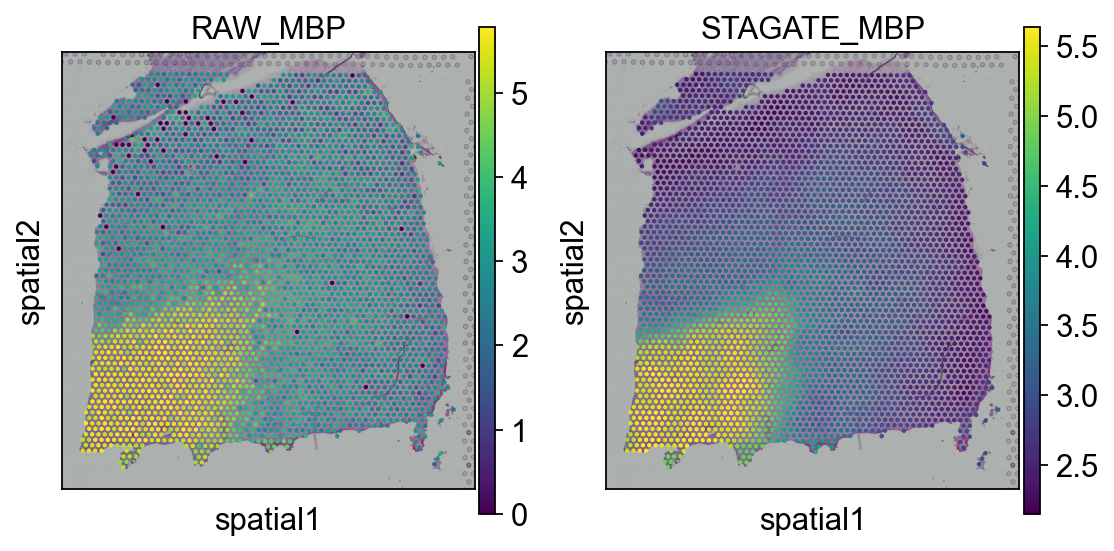

In [17]:
plot_gene = 'MBP'
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=plot_gene, show=False, ax=axs[1], title='STAGATE_'+plot_gene, layer='STAGATE_ReX', vmax='p99')


## Calculated the Pseudo-Spatial Map

We compared the model results from `SpaceFlow` and `STAGATE`, and to our surprise, STAGATE can also be applied to predict pSM.

In [ ]:
STA_obj.cal_pSM(n_neighbors=20,resolution=1,
                       max_cell_for_subsampling=5000)
#adata

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP


In [ ]:
sc.pl.spatial(adata, color=['pSM_STAGATE','Ground Truth'],
             cmap='RdBu_r')